In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from cycle_detection import detect_respiration_cycles
from respiration_features import get_all_respiration_features
from params import patient, respi_chan, srate , rsp_detect_sign
import ghibtools as gh
%matplotlib widget

## LOAD 

In [25]:
patient

'P10'

In [26]:
save = True

In [27]:
da = xr.load_dataarray(f'../dataarray/da_N2N3_{patient}.nc').sel(chan = respi_chan)

## TOOLS

In [28]:
def rsp_cycle_detection(resp_sig, srate=srate):

    cycles = detect_respiration_cycles(resp_sig, sampling_rate=srate, t_start = 0., output = 'index',

                                    # preprocessing
                                    inspiration_sign = '+',
                                    high_pass_filter = None,
                                    constrain_frequency = None,
                                    median_windows_filter = None,

                                    # baseline
                                    baseline_with_average = True,
                                    manual_baseline = 0.,

                                    # clean
                                    eliminate_time_shortest_ratio = 2,
                                    eliminate_amplitude_shortest_ratio = 10,
                                    eliminate_mode = 'OR', # 'AND'

                                    )

    return cycles

## CYCLE DETECTION

In [29]:
rsp = da.values
t = da.coords['time'].values
cycles = rsp_cycle_detection(rsp)
inspis = cycles[:,0]
expis = cycles[:,1]

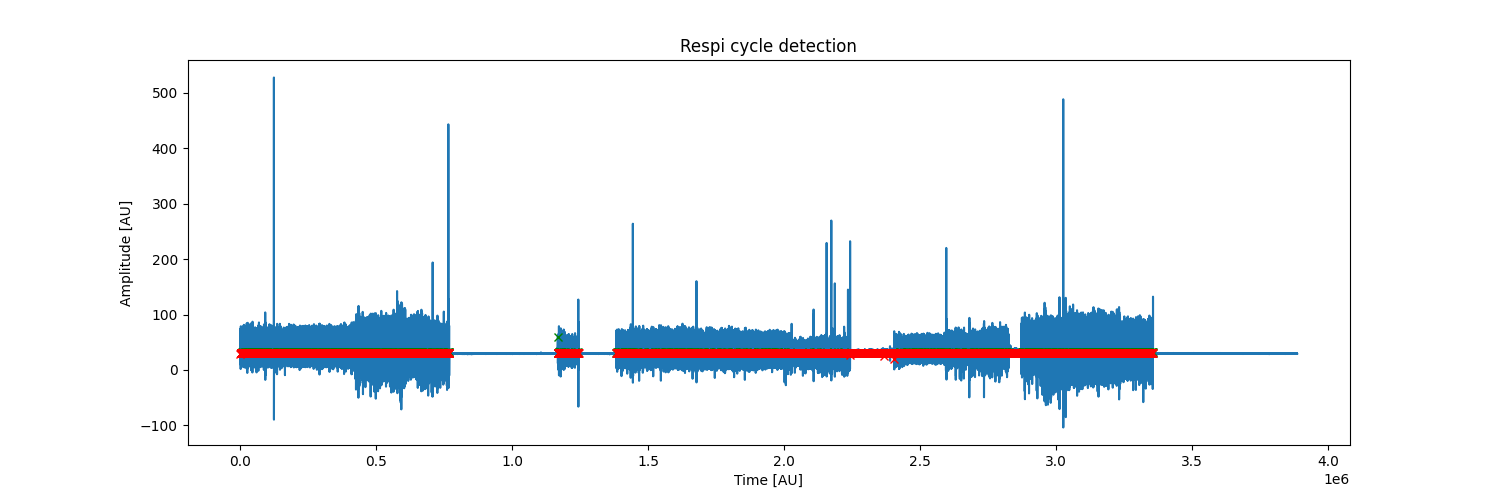

In [30]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(rsp)
ax.plot(inspis, rsp[inspis], 'x', color = 'g')
ax.plot(expis, rsp[expis], 'x', color = 'r')
ax.set_title(f'Respi cycle detection')
ax.set_ylabel('Amplitude [AU]')
ax.set_xlabel('Time [AU]')
plt.show()

## RESP FEATURES FROM CYCLES & RESP

In [31]:
duration_min=1.5
duration_max = 20
inspi_min=0.5
inspi_max=10

In [32]:
resp_features = get_all_respiration_features(resp_sig=rsp, sampling_rate=srate, cycles=cycles, t_start = 0.)
resp_features.insert(0, 'participant',patient)
initial_n_cycles = resp_features.shape[0]
clean_cycles = []
for i , cycle in resp_features.iterrows():
    if cycle['cycle_duration'] > duration_min and cycle['cycle_duration'] < duration_max and cycle['insp_duration'] > inspi_min and cycle['insp_duration'] < inspi_max and cycle['exp_duration'] > inspi_min and cycle['exp_duration'] < inspi_max:
        clean_cycles.append(cycle)

df_return = pd.concat(clean_cycles, axis = 1).T

print(f'{initial_n_cycles - df_return.shape[0]} cycles removed')
if save:
    print('SAVING')
    df_return.to_excel(f'../df_analyse/resp_features_{patient}.xlsx')


/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'objec

7 cycles removed
SAVING


In [33]:
resp_features[['cycle_duration','insp_duration','exp_duration','cycle_freq']].mean()

cycle_duration    3.962379
insp_duration     1.190126
exp_duration      2.772253
cycle_freq        0.306641
dtype: float64